# BAIS 6040 Data Programming in Python

## Spring 2021

## Week 9, Homework 7

## Notebook 2 - Results of Machine Learning Analysis

## Group 3: Jared Barkley, Tyler Zaruba, Netaji Boggarapu, Michael Noonan

In [5]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [6]:
# Import project data

compiledcountydata_dir = "https://raw.githubusercontent.com/jaredbarkley0/PythonGroupProject/master/MN%20County%20Data_032721.csv"
compiledcountydata = pd.read_csv(compiledcountydata_dir)
compiledcountydata

,Unnamed: 0,County,Total Positive Cases,Total Deaths,Population,Rate of Infection,Death Rate,Pop Density,Mean Household Size,Congregate Living Population,No. of Cases in Nursing Homes,No. of Nursing Homes in County,"Nursing Home Cases, % of Total",Cases per number of Nursing Home
0,0,Aitkin,1191,33,15870.0,0.075047,36.090909,8.0,2.097233,254.0,118.0,4.0,0.099076,NaN
1,1,Anoka,33391,390,362648.0,0.092076,85.617949,753.9,2.712716,3753.0,1675.0,35.0,0.050163,NaN
2,2,Becker,3131,42,34545.0,0.090635,74.547619,22.8,2.393929,477.0,294.0,8.0,0.093900,NaN
3,3,Beltrami,3386,51,47184.0,0.071762,66.392157,14.8,2.487013,1990.0,264.0,11.0,0.077968,NaN
4,4,Benton,4482,90,40895.0,0.109598,49.800000,94.4,2.426614,1050.0,557.0,11.0,0.124275,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,82,Watonwan,1176,8,10923.0,0.107663,147.000000,25.4,2.397507,151.0,36.0,3.0,0.030612,NaN
83,83,Wilkin,677,11,6226.0,0.108738,61.545455,8.7,2.238850,152.0,36.0,2.0,0.053176,NaN
84,84,Winona,4193,49,50830.0,0.082491,85.571429,79.9,2.352632,3855.0,277.0,9.0,0.066062,NaN
85,85,Wright,12554,116,138531.0,0.090622,108.224138,178.3,2.796739,1158.0,687.0,20.0,0.054724,NaN


In [7]:
# Check dataframe summary info

compiledcountydata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        87 non-null     int64  
 1   County                            87 non-null     object 
 2   Total Positive Cases              87 non-null     int64  
 3   Total Deaths                      87 non-null     int64  
 4   Population                        87 non-null     float64
 5   Rate of Infection                 87 non-null     float64
 6   Death Rate                        87 non-null     float64
 7   Pop Density                       87 non-null     float64
 8   Mean Household Size               87 non-null     float64
 9   Congregate Living Population      87 non-null     float64
 10  No. of Cases in Nursing Homes     87 non-null     float64
 11  No. of Nursing Homes in County    87 non-null     float64
 12  Nursing Ho

## Question 1 - What algorithm, of the ones attempted, appear to provide the best results, and why?

## Question 2 - What features ended up being the most interesting/meaningful for your test?

To begin analysis of the features of our data, we first created a correlation matrix in pandas an plotted it to a Seaborn heat map to give a quick visual of correlations within our data

<AxesSubplot:>

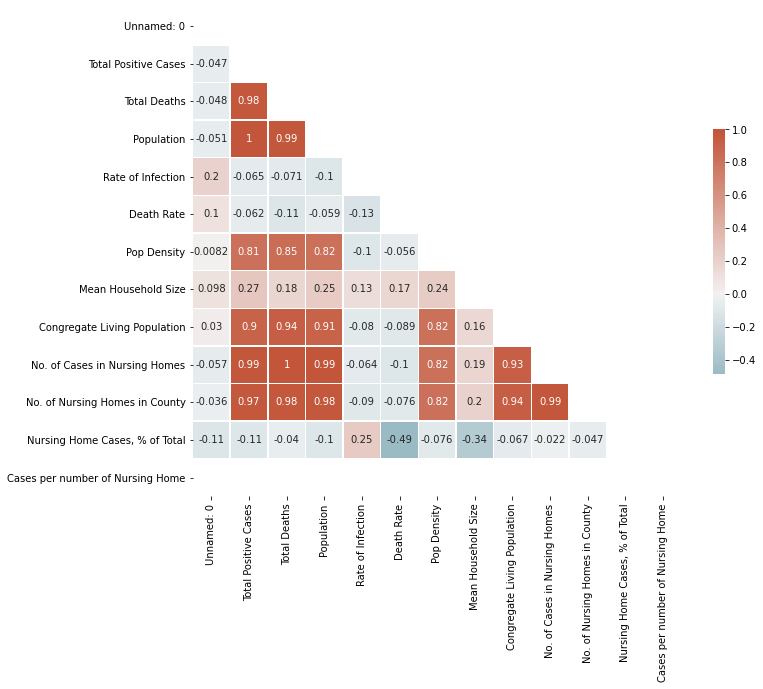

In [8]:
# Create a correlation matrix as a heat map

corr = compiledcountydata.corr()
f, ax = plt.subplots(figsize=(11, 9))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, annot=True, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Analysis of the correlation matrix indicates we may have high multicollinearity between our variables.  Population, Total Positive Cases, Total Deaths and No. of Cases in Nursing Homes have an almost perfect relationship, suggesting that they are essentially measuring the same thing.  Categories which may be interesting to analyze are the Infection Rate, Death Rate, and total number of deaths.  Since Population, Total Deaths, Total Positive Cases and No. of Cases in Nursing Homes all have correlations greater than 98%. Feature analysis will include Total Deaths as a target of interest, but will not use the other highly correlated variables as explaining variables.

The initial question for our project was to see if we could identify any geospatial or community level characteristics that would correlate highly with increased spread of Covid or increased risk of death from covid.  To begin our analysis, we decided to investigate Rate of Infection, Total Deaths, and Death Rate as potential target variables.  Again, we wanted to avoid highly correlated variables that appeared to have extreme multicollinearity.  For consistency, we will evaluate each of our target variables of interest against the same explainer variables - Population density, Mean Household Size and Nursing Home Cases, % of Total.  These explainer variableswere selected